In [1]:
%matplotlib inline
import grale.gridfunction as gridfunction
import grale.grid as grid
import grale.plotutil as plotutil
import grale.feedback as feedback
import grale.renderers as renderers
import grale.cosmology as cosmology
import grale.lenses as lenses
import grale.images as images
import grale.inversion as inversion
from grale.constants import *
from astropy.io import fits
from astropy import wcs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import os
import glob
import fmtutil

plt.rcParams.update({'font.size': 12})

renderers.setDefaultLensPlaneRenderer("threads")
renderers.setDefaultMassRenderer("threads")
feedback.setDefaultFeedback("notebook")
plotutil.setDefaultAngularUnit(ANGLE_ARCSEC)

cosm = cosmology.Cosmology(0.7, 0.27, 0, 0.73)
cosmology.setDefaultCosmology(cosm)
D = cosm.getAngularDiameterDistance

zd, zs = 0.4, 3.0
strongSize = 250*ANGLE_ARCSEC

fullLens = lenses.GravitationalLens.load("truelens.lensdata")
critDens = fullLens.getCriticalDensity(D(zs),D(zd,zs))

V = lambda x,y: np.array([x,y], dtype=np.double)

In [2]:
def saveFig(fn):
    plt.savefig(fn, bbox_inches="tight")

# Due to a change in the grale code, a shear weight must now be present in an imagesdata
# file. This adds a default if not.
def checkShearWeight(img):
    props = img.getKnownPropertyNames()
    if 'shearweight' in props:
        return img
    
    props = { p: True for p in props }
    props['shearweight'] = True
    newImg = images.ImagesData(img.getNumberOfImages(), **props)
    
    for i in range(img.getNumberOfImages()):
        for pt in img.getImagePoints(i):
            pt["shearweight"] = 1.0
            newImg.addPoint(i, **pt)
    return newImg

def getWLFitness(lensModel, shearInfo, oneMinusKappaThreshold):
    iws = inversion.InversionWorkSpace(zd, strongSize)
    for imgData,zs in shearInfo:
        iws.addImageDataToList(checkShearWeight(imgData), zs, "sheardata", {"threshold": oneMinusKappaThreshold})
    return iws.calculateFitness(lensModel)[0][0]

if 0:
    def getShearImgData(shearFileName):
            info = []
            curDir = os.getcwd()
            dirPrefix = "./"
            try:
                os.chdir(dirPrefix)
                fileNames = glob.glob(shearFileName.replace("Z", "*"))
                if not fileNames:
                    print(f"No fileNames found for {shearFileName} in {os.getcwd()}")
                    raise Exception("No shear files found")

                for fn in fileNames:
                    weakZ = None
                    parts = ".".join(fn.split(".")[:-1]).split("_")
                    for p in parts:
                        if p.startswith("z") and len(p) > 1:
                            weakZ = float(p[1:])
                            break

                    if weakZ is None:
                        raise Exception("No Z")

                    imgDat = images.ImagesData.load(fn)
                    print("Loading", fn)
                    info.append((imgDat, weakZ))
            finally:
                os.chdir(curDir)

            return info
else:
    def getShearImgData(shearFileName):
        l = [ ]
        for fn, z in fmtutil.getFileNamesAndRedshifts(shearFileName):
            print("Loading", fn, "z=", z)
            imgDat = images.ImagesData.load(fn)
            l.append((imgDat, z))
        return l

def getSheetDensities():
    return [-0.2, -0.025] + np.linspace(0.001,critDens,20).tolist()
    
def getOptInfo(shearInfo, xOffset = 0, yOffset= 0):
    densities, factors, fitnesses, models = [], [], [], []
    import scipy.optimize

    for sheetDens in getSheetDensities():
        sheetLens = lenses.MassSheetLens(fullLens.getLensDistance(), { "density": sheetDens })

        bestLens, bestFitness, bestFactor = None, float("inf"), 0

        def createLens(scaleFactor):
            return lenses.CompositeLens(fullLens.getLensDistance(), [
                { "factor": scaleFactor, "x": xOffset , "y": yOffset, "angle": 0, "lens": fullLens },
                { "factor": 1, "x": 0, "y": 0, "angle": 0, "lens": sheetLens }
            ])

        def getFitness(lens):
            return getWLFitness(lens, shearInfo, 0.1)

        def f(scaleFactor):
            return getFitness(createLens(scaleFactor))

        res = scipy.optimize.minimize_scalar(f, (0.1,0.5))
        bestFactor = res.x
        bestLens = createLens(bestFactor)
        bestFitness = getFitness(bestLens)

        print(f"sheetDens = {sheetDens} scaleFactor = {bestFactor} fitness = {bestFitness}")
        densities.append(sheetDens)
        fitnesses.append(bestFitness)
        models.append(bestLens)
        factors.append(bestFactor)
        
    return densities, factors, fitnesses, models

In [3]:
optExact = getOptInfo(getShearImgData("shear_mr_48x48_exact_zZ.imgdata"))

Loading ./shear_mr_48x48_exact_z1.imgdata z= 1.0
Loading ./shear_mr_48x48_exact_z2.imgdata z= 2.0
Loading ./shear_mr_48x48_exact_z4.imgdata z= 4.0
sheetDens = -0.2 scaleFactor = 1.0455987401709461 fitness = 2.2022e-06
sheetDens = -0.025 scaleFactor = 1.005709299403986 fitness = 3.67847e-08
sheetDens = 0.001 scaleFactor = 0.9997714880743267 fitness = 5.93691e-11
sheetDens = 0.21578245786739186 scaleFactor = 0.9502383250977133 fitness = 2.84608e-06
sheetDens = 0.4305649157347837 scaleFactor = 0.9008160241493369 fitness = 1.17966e-05
sheetDens = 0.6453473736021756 scaleFactor = 0.8510793352502716 fitness = 2.96404e-05
sheetDens = 0.8601298314695675 scaleFactor = 0.8005362488538676 fitness = 5.0759e-05
sheetDens = 1.0749122893369591 scaleFactor = 0.7498251381329265 fitness = 8.79194e-05
sheetDens = 1.2896947472043512 scaleFactor = 0.6975406919565018 fitness = 0.000140404
sheetDens = 1.504477205071743 scaleFactor = 0.6436410305261991 fitness = 0.000206203
sheetDens = 1.7192596629391348 scal

In [4]:
optEll100 = getOptInfo(getShearImgData("shear_ell_48x48_pointavg_100_zZ.imgdata"))

Loading ./shear_ell_48x48_pointavg_100_z1.imgdata z= 1.0
Loading ./shear_ell_48x48_pointavg_100_z2.imgdata z= 2.0
Loading ./shear_ell_48x48_pointavg_100_z4.imgdata z= 4.0
sheetDens = -0.2 scaleFactor = 1.0461038395906548 fitness = 0.00174909
sheetDens = -0.025 scaleFactor = 1.006132463845281 fitness = 0.00174752
sheetDens = 0.001 scaleFactor = 1.0001328037394348 fitness = 0.00174758
sheetDens = 0.21578245786739186 scaleFactor = 0.9505836465002117 fitness = 0.00175126
sheetDens = 0.4305649157347837 scaleFactor = 0.9012984041090579 fitness = 0.00176107
sheetDens = 0.6453473736021756 scaleFactor = 0.845846077615347 fitness = 0.00177752
sheetDens = 0.8601298314695675 scaleFactor = 0.8004558488339805 fitness = 0.00180204
sheetDens = 1.0749122893369591 scaleFactor = 0.7497447021210224 fitness = 0.00184034
sheetDens = 1.2896947472043512 scaleFactor = 0.6975148925029824 fitness = 0.00189412
sheetDens = 1.504477205071743 scaleFactor = 0.6435124711944393 fitness = 0.00196063
sheetDens = 1.719259

In [5]:
optRndGauss60 = getOptInfo(getShearImgData("shear_zZ_gaussian_48x48_sigma60.000_nocentral120.imgdata"))

Loading ./shear_z0.480_gaussian_48x48_sigma60.000_nocentral120.imgdata z= 0.48
Loading ./shear_z0.554_gaussian_48x48_sigma60.000_nocentral120.imgdata z= 0.554
Loading ./shear_z0.656_gaussian_48x48_sigma60.000_nocentral120.imgdata z= 0.656
Loading ./shear_z0.795_gaussian_48x48_sigma60.000_nocentral120.imgdata z= 0.795
Loading ./shear_z1.045_gaussian_48x48_sigma60.000_nocentral120.imgdata z= 1.045
Loading ./shear_z1.502_gaussian_48x48_sigma60.000_nocentral120.imgdata z= 1.502
Loading ./shear_z13.435_gaussian_48x48_sigma60.000_nocentral120.imgdata z= 13.435
Loading ./shear_z2.723_gaussian_48x48_sigma60.000_nocentral120.imgdata z= 2.723
sheetDens = -0.2 scaleFactor = 0.8736536399105636 fitness = 0.00127421
sheetDens = -0.025 scaleFactor = 0.8375259299783685 fitness = 0.00127468
sheetDens = 0.001 scaleFactor = 0.8317927010720231 fitness = 0.00127475
sheetDens = 0.21578245786739186 scaleFactor = 0.7877692437466309 fitness = 0.00127554
sheetDens = 0.4305649157347837 scaleFactor = 0.7420067658

In [6]:
def plotFactorForDens(res):
    plt.plot(np.array(res[0])/critDens, res[1], color="black")
    plt.plot(np.array(res[0])/critDens, res[1], ".", color="black")
    plt.gca().set_xlabel("$\kappa_s$")
    plt.gca().set_ylabel("$\lambda_{opt}$")

def plotFitnessForDens(res):
    plt.plot(np.array(res[0])/critDens, res[2], color="black")
    plt.plot(np.array(res[0])/critDens, res[2], ".", color="black")
    plt.gca().set_ylim(bottom=0)
    plt.gca().set_xlabel("$\kappa_s$")
    plt.gca().set_ylabel("$fitness_{WL}$")

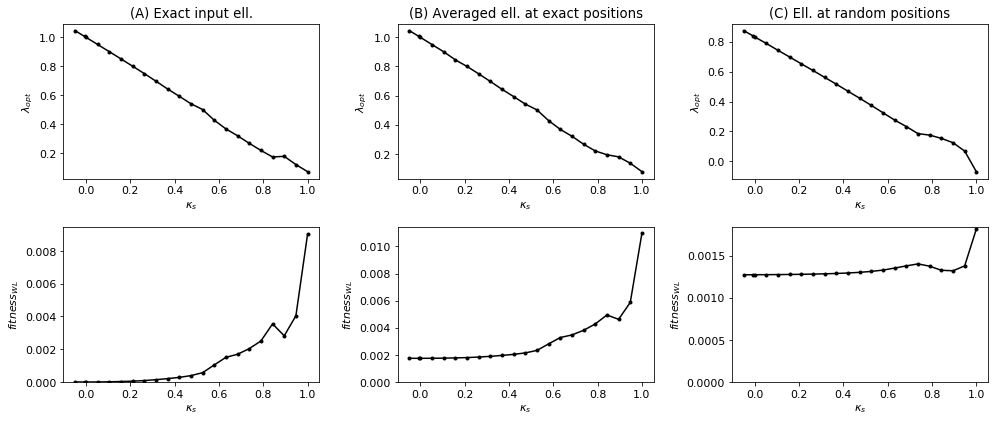

In [7]:
plt.rcParams.update({'font.size': 11})
plt.figure(figsize=(14,6))
for sp, opt, title in [
    (1, optExact, "(A) Exact input ell."),
    (2, optEll100, "(B) Averaged ell. at exact positions"),
    (3, optRndGauss60, "(C) Ell. at random positions"),
    ]:
    plt.subplot(2,3,sp)
    plt.gca().set_title(title)
    plotFactorForDens(opt)

for sp, opt in [ 
    (4, optExact),
    (5, optEll100),
    (6, optRndGauss60),
  ]:
    plt.subplot(2,3,sp)
    plotFitnessForDens(opt)

plt.tight_layout()